In [1]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    df = engine.calculateDailyResult()
    return df

In [73]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'MultiFrameMaStrategy'
    author = 'Haolin Pan'
    
    # 策略参数
    fastPeriod = 20
    slowPeriod = 40
    BBandPeriod = 20
    rsiPeriod = 11
    stopRatio = 0.04
    Threshold = 0.005
    lot = 1
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    rsiTrend = {} #记录rsi状态，超卖1，超买-1
    turnOver = {} #记录反转状态，空转多1，多转空-1
    trend = {}
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'fastPeriod',
                 'slowPeriod',
                 'BBandPeriod',
                 'rsiPeriod',
                 'stopRatio',
                 'Threshold'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'maTrend',
               'transactionPrice',
                'rsiTrend',
                'turnOver'
                'trend'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.rsiTrend = {s:0 for s in self.symbolList}
        self.turnOver = {s:0 for s in self.symbolList}
        self.trend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):#达到止损价位或反转
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif (bar.close > longProfit):#达到止盈价位且反转
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):#达到止损价位或反转
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):#达到止盈价位且反转
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        #布林通道
        up, mid, low = ta.BBANDS(am60.close, self.BBandPeriod) 
        
        #布林带开口
        sigma = (up-mid)/(mid*2)
        
        if sigma[-1]>self.Threshold and sigma[-2]<self.Threshold :
            self.trend[symbol]=1
        elif sigma[-1]<self.Threshold and sigma[-2]>self.Threshold:
            self.trend[symbol]=0
            
        # 计算均线并判断趋势        
        fastMa = ta.MA(am60.close, self.fastPeriod)
        slowMa = ta.MA(am60.close, self.slowPeriod)
        
        #均线金叉
        if fastMa[-1]>slowMa[-1] and fastMa[-2]<slowMa[-2]:
            self.maTrend[symbol] = 1
        #均线死叉
        elif fastMa[-1]<slowMa[-1] and fastMa[-2]>slowMa[-2]:
            self.maTrend[symbol] = -1

    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return
        #rsi
        rsi = ta.RSI(am15.close, self.rsiPeriod)
        
        if rsi[-1]<30 and rsi[-2]>30: #进入超卖区间
            self.rsiTrend[symbol]=1
        elif rsi[-1]>70 and rsi[-2]<70: #进入超买区间
            self.rsiTrend[symbol]=-1

        #rsi趋势      
        rsiUp = rsi[-1]>rsi[-2]*1.4
        rsiDn = rsi[-1]<rsi[-2]*0.8
        
        #均线
        fastMa = ta.MA(am15.close, self.fastPeriod)
        slowMa = ta.MA(am15.close, self.slowPeriod)
        
        #反转
        if self.maTrend[symbol] == -1 and fastMa[-1]>fastMa[-3]:
            self.turnOver[symbol]=1
        elif self.maTrend[symbol] == 1 and fastMa[-1]<fastMa[-3]:
            self.turnOver[symbol]=-1
        
        #进出场
        if self.trend[symbol]==1:#趋势行情
            #rsi超卖且上升，快均线回头
            if rsiUp and (self.rsiTrend[symbol] == 1) and (self.turnOver[symbol]==1) and (self.posDict[symbol+'_LONG']==0) :
                if  (self.posDict[symbol+'_SHORT']==0):
                    self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
                elif (self.posDict[symbol+'_SHORT'] > 0):
                    self.cancelAll() # 撤销挂单
                    self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                    self.buy(symbol, bar.close*1.01, self.lot)
            #rsi超买且下降，快均线回头
            if rsiDn and (self.rsiTrend[symbol] == -1) and (self.turnOver[symbol]==-1) and (self.posDict[symbol+'_SHORT']==0) :
                if (self.posDict[symbol+'_LONG']==0):
                    self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
                elif (self.posDict[symbol+'_LONG'] > 0):
                    self.cancelAll() # 撤销挂单
                    self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                    self.short(symbol, bar.close*0.99, self.lot)
        
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
            print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MultiFrameMaStrategy.on60MinBar at 0x0000024552F5F9D8>, <__main__.MultiFrameMaStrategy object at 0x0000024552F65198>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x0000024552F5F8C8>, <__main__.MultiFrameMaStrategy object at 0x0000024552F65198>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x0000024552F5F950>, <__main__.MultiFrameMaStrategy object at 0x0000024552F65198>)
2018-12-23 03:22:37.148753	开始回测
2018-12-23 03:22:37.148753	策略初始化
2018-12-23 03:22:37.149750	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-23 03:22:37.550677	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-23 03:22:37.553701	载入完成，数据量：12000
2018-12-23 03:22:37.553701	策略初始化完成
2018-12-23 03:22:37.553701	策略启动完成
2018-12-23 03:22:37.553701	开始回放回测数据,回测范围:[20180601 12:00,20

Traceback (most recent call last):
  File "C:\Users\49978\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\Users\49978\Anaconda3\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.48, 'close': 7483.45, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 294.761681, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531111500 , 20180601120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 

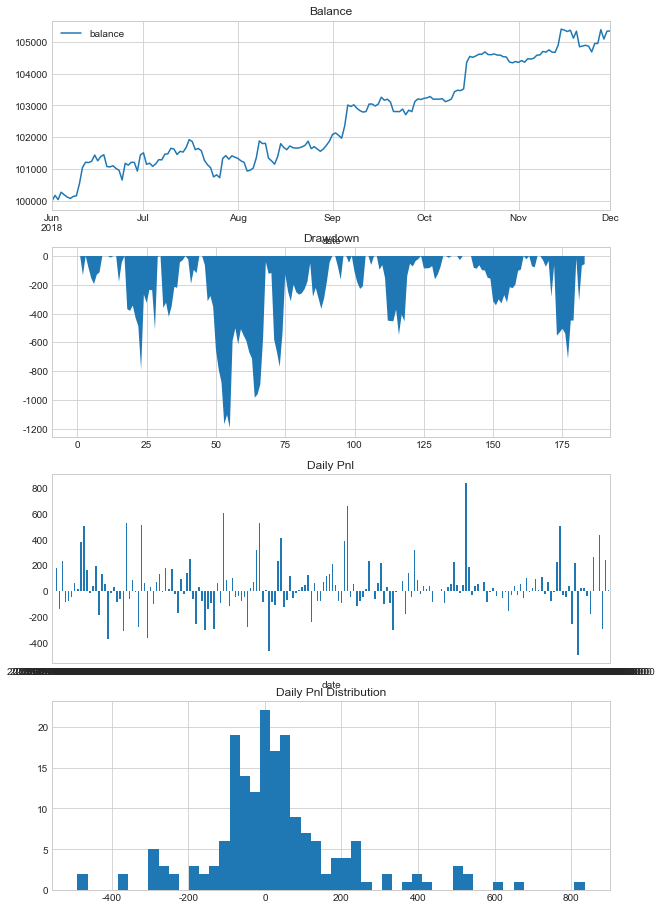

2018-12-23 03:23:06.329706	计算回测结果
2018-12-23 03:23:06.335689	------------------------------
2018-12-23 03:23:06.335689	第一笔交易：	2018-06-03 05:00:00
2018-12-23 03:23:06.335689	最后一笔交易：	2018-12-01 11:58:00
2018-12-23 03:23:06.335689	总交易次数：	71
2018-12-23 03:23:06.335689	总盈亏：	5,334.72
2018-12-23 03:23:06.335689	最大回撤: 	-1,239.58
2018-12-23 03:23:06.335689	平均每笔盈利：	75.14
2018-12-23 03:23:06.335689	平均每笔滑点：	0.0
2018-12-23 03:23:06.335689	平均每笔佣金：	6.25
2018-12-23 03:23:06.335689	胜率		59.15%
2018-12-23 03:23:06.335689	盈利交易平均值	301.83
2018-12-23 03:23:06.335689	亏损交易平均值	-253.18
2018-12-23 03:23:06.335689	盈亏比：	1.19


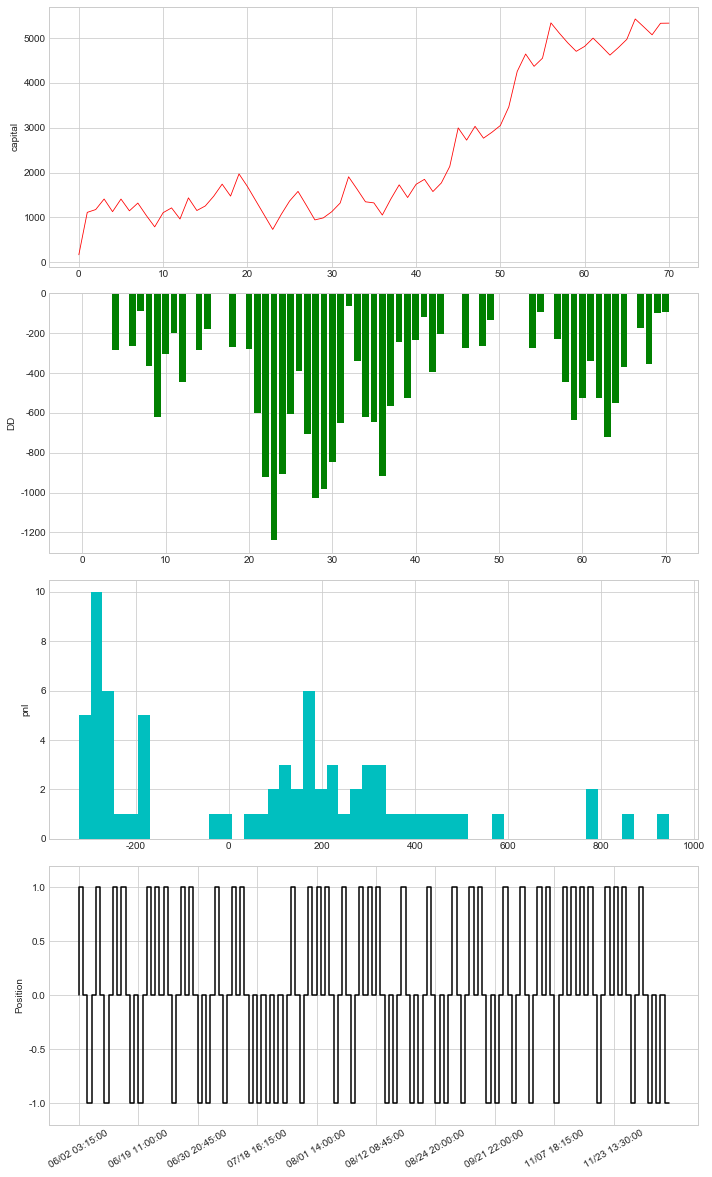

2018-12-23 03:23:06.952042	计算按日统计结果


In [74]:
MultiFrameMaDf = runBacktesting(MultiFrameMaStrategy, {'symbolList':['BTCUSDT:binance']} , '20180601 12:00', \
                            '20181201 12:00', 0.002, 5/10000)